# Predicting Secondary Student Final Grades from Student Age, Absence count, and Prior Grades

## Introduction
Secondary students are in an important time of development, and educating them is a top priority for leading them to successful lives. If we are able to identify the effect of other variables on student performance, it could provide insight on how to identify students that need extra assistance, as well as better understand their performance in general.
The question we would like to answer with our project is: Given a secondary student’s age, total number of absences, and grades in the earlier two periods (G1 and G2), how can we predict a student’s final grade, G3?
The data set we will be using is titled “Student Performance”, and is obtained from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Student+Performance). 
 The dataset records attributes of students who are taking math at two Portugese schools.  Examples of variables mainly include student traits (e.g. travel time to school, amount of free-time after school, age, number of school absences), and finally the student’s performance (grades in 1st period, 2nd period, and final grade)


## Primary Data Analysis

In [3]:
library(tidyverse)
library(tidymodels)
library(grid)
library(gridExtra)

set.seed(100)
# Gabriel Pereira

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [4]:
# Download the file and read into notebook
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip",temp)
school_data <- read_csv2(unz(temp, "student-mat.csv"))
unlink(temp)

# Select relevant columns
school_data <- school_data %>% filter(school == "GP") %>%
    select(age,absences,G1,G2,G3)
head(school_data)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



age,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,6,5,6,6
17,4,5,5,6
15,10,7,8,10
15,2,15,14,15
16,4,6,10,10
16,10,15,15,15


In [5]:
#see if predictors are linear

In [6]:
# Checks to see if the dataframe has any NA values. 
any(is.na(data))

Warning message in is.na(data):
“is.na() applied to non-(list or vector) of type 'closure'”


[1] FALSE

In [7]:
# Split data into training and testing. Strata by age to ensure the
# the sample has 
school_split <- initial_split(school_data, prop = 3/4, strata = age)
school_training <- training(school_split)
school_testing <- testing(school_split)

What is the students predicted final grade, based on their previous quarter grades, studytime, and number of absences?

In [12]:
G1_scatterplot <- ggplot(school_training, aes(x = G1, y = G3, alpha = 0.3)) +
                geom_point(position = "jitter") +
                labs(title = "Figure 1",
                     x = "First Trimester Grades (Out of 20)",
                     y = "Third Trimester Grades (Out of 20)") +
                theme(text = element_text(size = 20),
                     legend.position = "none")
G2_scatterplot <- ggplot(school_training, aes(x = G2, y = G3, alpha = 0.3)) +
                geom_point(position = "jitter") +
                labs(title = "Figure 2",
                     x = "Second Trimester Grades (Out of 20)",
                     y = "Third Trimester Grades (Out of 20)") +
                theme(text = element_text(size = 20),
                     legend.position = "none")
absences_scatterplot <- ggplot(school_training, aes(x = absences, y = G3, alpha = 0.3)) +
                geom_point(position = "jitter") +
                labs(title = "Figure 3",
                     x = "Number of Absences",
                     y = "Third Trimester Grades (Out of 20)") +
                theme(text = element_text(size = 20),
                     legend.position = "none")
age_boxplot <- 
    school_training %>%
    mutate(age = as_factor(age)) %>%
    mutate(age = case_when(age == "15" ~ "Age 15",
                          age == "16" ~ "Age 16",
                          age == "17" ~ "Age 17",
                          age == "18" ~ "Age 18",
                          age == "19" ~ "Age 19",
                          age == "20" ~ "Age 20",
                          age == "22" ~ "Age 22")) %>%
    ggplot() +
    geom_boxplot(aes(y= G3, fill = age)) +
    facet_grid(. ~ age) +
    labs(title = "Figure 4", y = "Third Trimester Grades (Out of 20)", fill = "Age") +
    theme(text = element_text(size = 20),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          legend.position = "none")

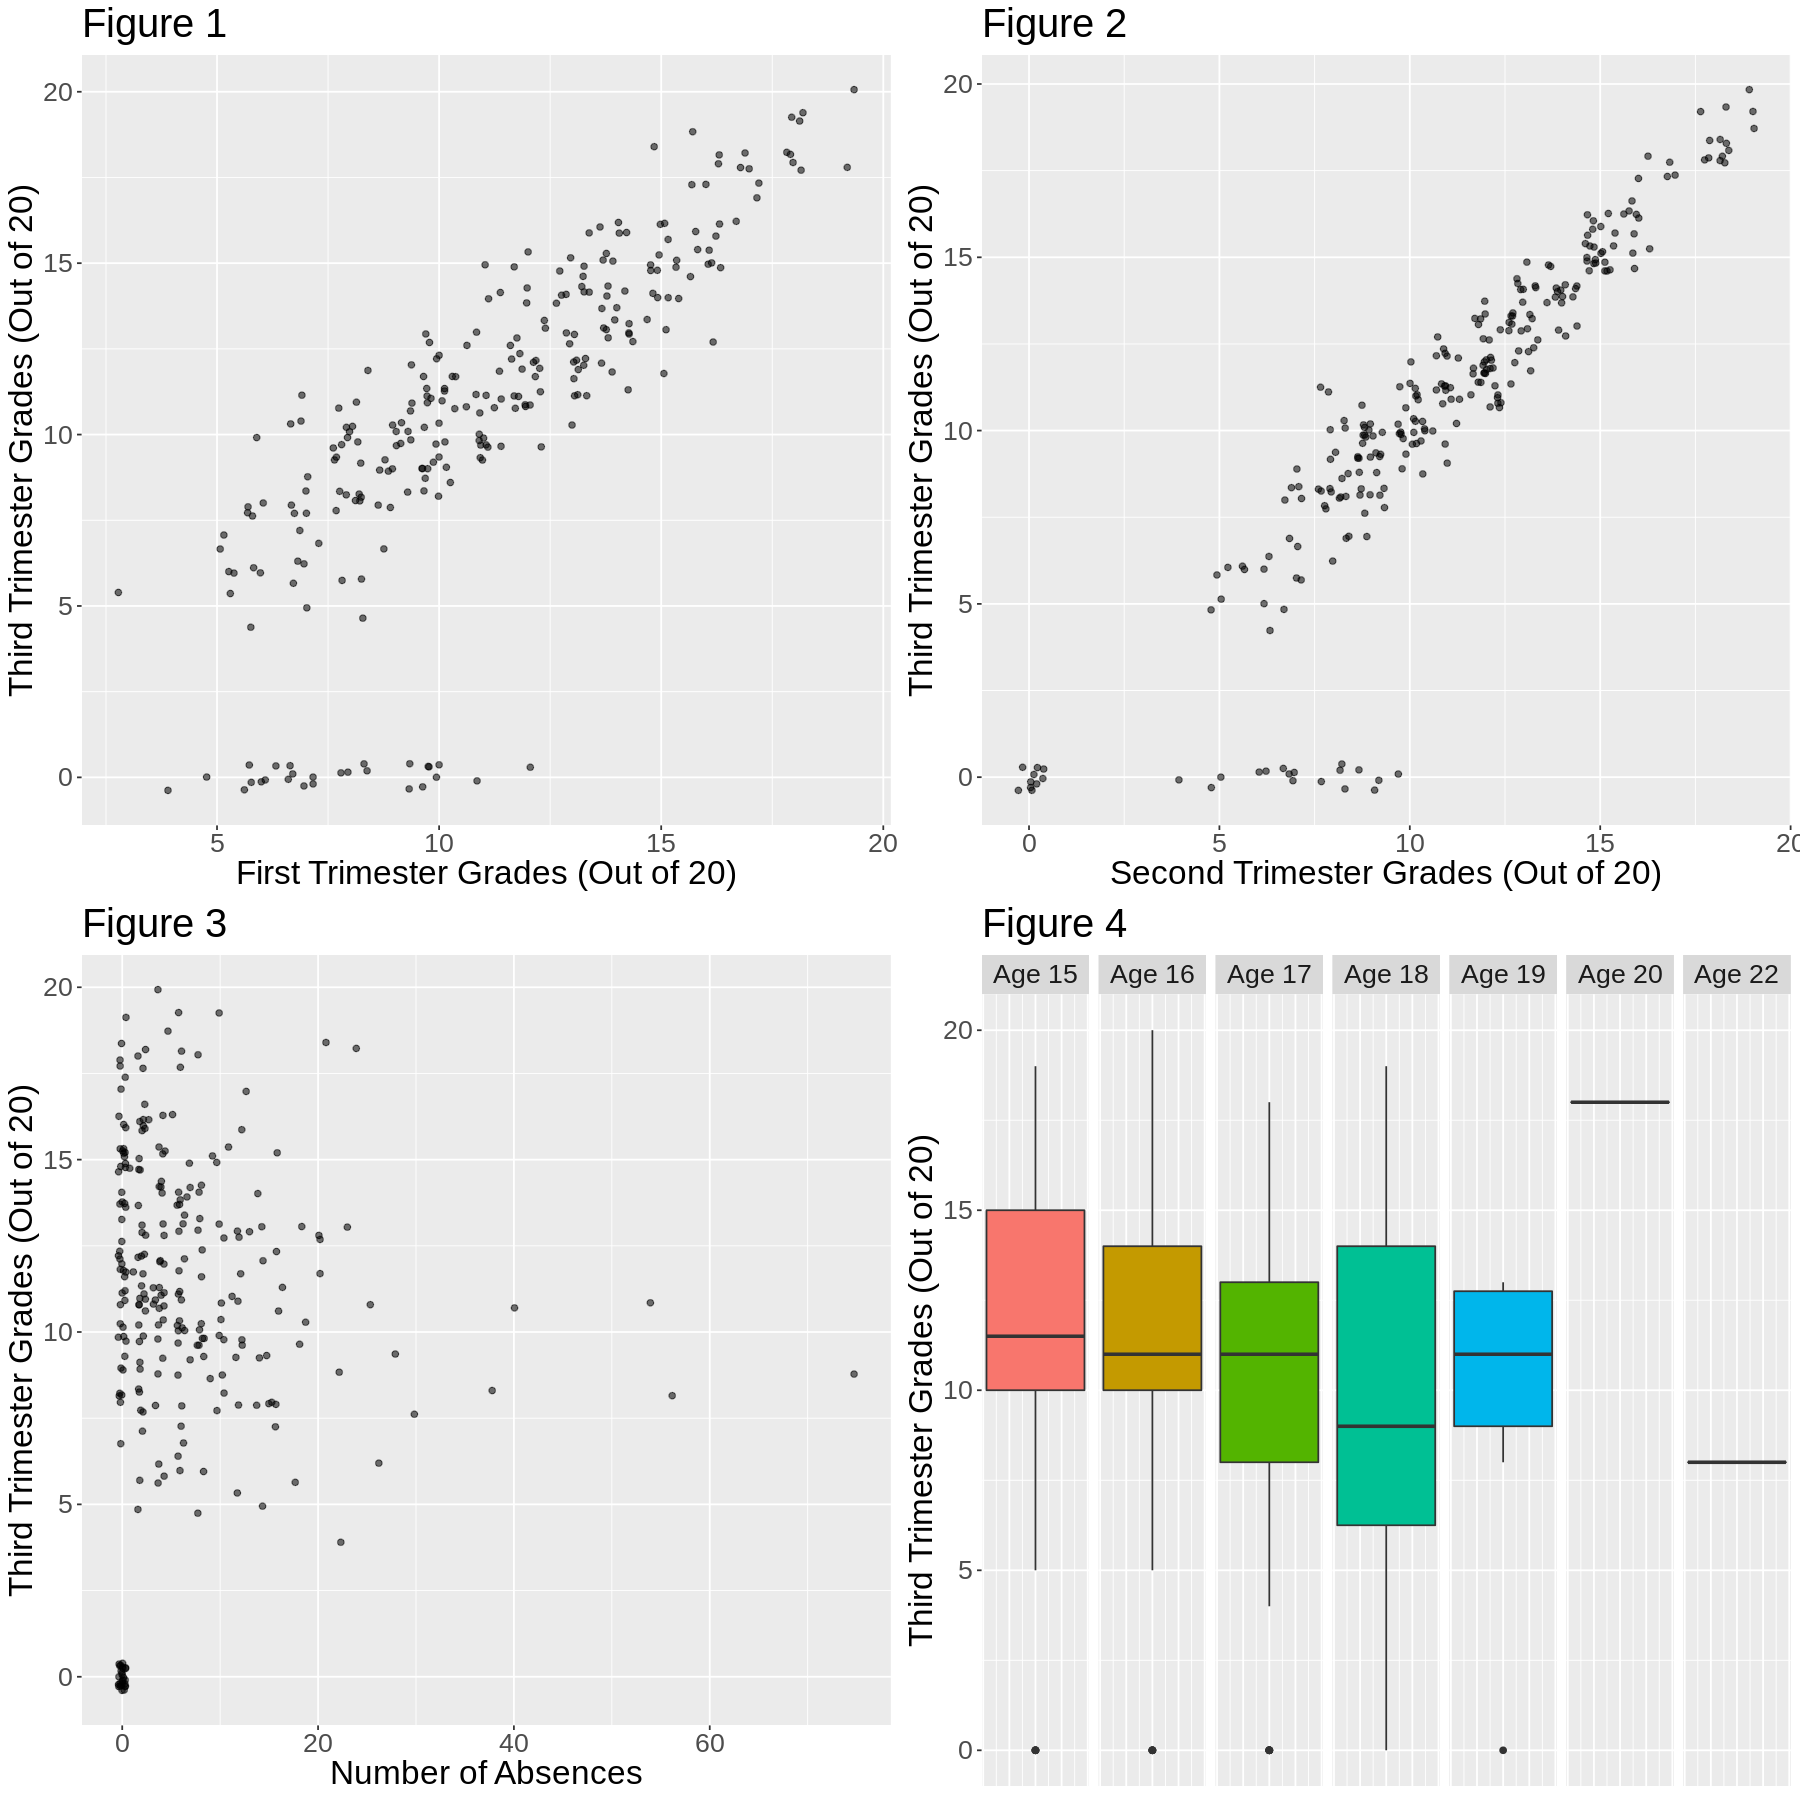

In [13]:
options(repr.plot.width = 15, repr.plot.height = 15)
grid.arrange(G1_scatterplot, G2_scatterplot, absences_scatterplot,age_boxplot,nrow = 2, ncol = 2)

| N = 262            | Age   | Absences | Grade 1 | Grade 2 | Grade 3 |
|--------------------|-------|----------|---------|---------|---------|
| Min                | 15.00 | 0.00     | 3.00    | 0.00    | 0.00    |
| Max                | 22.00 | 75.00    | 19.00   | 19.00   | 20.00   |
| Mean               | 16.54 | 6.35     | 11.11   | 10.94   | 10.60   |
| Median             | 16.00 | 4.00     | 11.00   | 11.00   | 11.00   |
| Standard Deviation | 1.22  | 9.10     | 3.39    | 3.92    | 4.77    |

In [14]:
summary(school_training)
sd(school_training$age)
sd(school_training$absences)
sd(school_training$G1)
sd(school_training$G2)
sd(school_training$G3)

      age           absences            G1              G2       
 Min.   :15.00   Min.   : 0.000   Min.   : 3.00   Min.   : 0.00  
 1st Qu.:16.00   1st Qu.: 0.000   1st Qu.: 8.00   1st Qu.: 9.00  
 Median :16.00   Median : 4.000   Median :11.00   Median :11.00  
 Mean   :16.54   Mean   : 6.346   Mean   :11.11   Mean   :10.94  
 3rd Qu.:17.00   3rd Qu.: 8.000   3rd Qu.:14.00   3rd Qu.:14.00  
 Max.   :22.00   Max.   :75.000   Max.   :19.00   Max.   :19.00  
       G3      
 Min.   : 0.0  
 1st Qu.: 8.5  
 Median :11.0  
 Mean   :10.6  
 3rd Qu.:14.0  
 Max.   :20.0  

[1] 1.228489

[1] 9.102368

[1] 3.391616

[1] 3.9219

[1] 4.769846

## Expected outcomes and significance

We expect to see that older students tend to get higher final grades, although there may also not be a clear pattern. We expect students with a lower amount of absences in the year to have higher grades, and finally we expect that there is a strong correlation between grades earlier in the year and final grade
The impact of the findings could allow the school administration or teachers to identify variables that have positive and negative effects on student grades, and to determine which students may need extra assistance to get on the right track.

Potential questions that this could lead to in the future include: 
- How could other variables be linked to G3? Some of the data, although potentially useful, were binary or categorical and so we couldn’t really use them. Finding a way to incorporate them into our predictions could prove beneficial.
- Do these patterns apply for other students as well? More specifically, performing this analysis on university students as well, where course content is much more difficult, may also provide meaningful results.
